<a href="https://colab.research.google.com/github/Quotermain/sber_stock_analysis/blob/main/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers

from google.colab import drive
drive.mount('/content/drive')

In [1]:
from transformers import AutoTokenizer
from transformers import BertForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup

In [2]:
import datetime

import pickle
  
import re

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)


In [3]:
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
  
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals
    
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):

    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        '''Берём только те значения из предсказаний и истинных лейблов, 
        которые равны классу текущей итерации (фильтруем)'''
        y_preds = preds_flat[labels_flat==label] # Тут и ошибочные предсказания
        y_true = labels_flat[labels_flat==label] # Тут будут только истинные
        
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [4]:
"""
Сбрасываю временные индексы на обычную нумерацию, т.к. теперь это просто задача
классификации. Также сбрасываю ненужные колонки.
"""

merged = pd.read_csv(
    'drive/MyDrive/data/merged.csv',
    usecols=[3, 5]
)

print(merged.head(1))

   target                                               text
0       1  Оптимистичные данные по занятости в США поднял...


In [4]:
"""Encodes labels to nums to put those in a model"""
label_dict = {'up': 0, 'down': 1, 'nothing': 2}
label_dict

{'down': 1, 'nothing': 2, 'up': 0}

# Loading prices

In [5]:
data = pd.read_csv(
    'drive/MyDrive/data/SBER.txt', 
    usecols=['<DATE>', '<TIME>', '<CLOSE>'],
    parse_dates=[['<DATE>', '<TIME>']],
    dayfirst=True
)
data.columns = ['datetime', 'close']
data.set_index('datetime', inplace=True)

data.head(1)

,close
datetime,
2009-01-11 10:30:00,23.01


###### Plots raw prices against time (per minute)

In [ ]:
plt.plot(data.close[-200:])
plt.title('Closing price of SBERBANK')
plt.ylabel('Closing price')
plt.xlabel('Date_time')
plt.grid(False)
plt.show()

###### Creates target: returns after 1 hour

In [28]:
data['returns_per_hour'] = data.close.pct_change(periods=15).shift(-15)
data.head(6)

,close,returns_per_hour,target
datetime,,,
2009-01-11 10:30:00,23.01,0.005650,up
2009-01-11 10:31:00,23.02,0.005213,up
2009-01-11 10:32:00,23.20,-0.002155,down
2009-01-11 10:33:00,23.22,-0.000861,down
2009-01-11 10:34:00,23.24,-0.001721,down
2009-01-11 10:35:00,23.14,0.000864,nothing


###### Plots histrogram of returns after 1 hour and plots them against time

In [ ]:
data.returns_per_hour.hist(bins=400)

In [ ]:
data.returns_per_hour.plot()

###### Explores returns

In [29]:
mean_returns = data.returns_per_hour.mean()
mean_returns

2.7778643895880957e-05

In [30]:
std_returns = data.returns_per_hour.std()
std_returns

0.003742760788228882

In [31]:
conditions = [
    data.returns_per_hour > 0.0007,
    data.returns_per_hour < -0.0007
]

choices = ["up", "down"]

data['target'] = np.select(conditions, choices, default='nothing')

In [32]:
data.target.value_counts()

up         552313
down       551010
nothing    458874
Name: target, dtype: int64

# Working with news

#### Cleaning parsed news

In [ ]:
news = pd.read_csv('drive/MyDrive/data/full_news.csv')

news.head()

In [ ]:
"""
Cleanes the text column from HTML markup, source of news,
\n, \r, \t and excess spaces
"""

news.text = news.text.apply(
    lambda x: re.sub(
        '<[^<]+?>|\n|\r|\t|© Reuters.|Investing.com — |  +', '', x
    )
)


'''
Extracts date and time
'''
news.datetime = news.datetime.str.extract(
    r'(\d+\.\d+\.\d+ \d+:\d+)'
)

In [ ]:
news.to_csv(
    'drive/MyDrive/data/full_news_cleaned.csv', 
    index=False
)

#### Loading cleaned news

In [33]:
news = pd.read_csv(
    'drive/MyDrive/data/full_news_cleaned.csv',
    dayfirst=True,
    parse_dates=True,
    index_col='datetime'
)

In [34]:
news.head()

,title,text
datetime,,
2020-11-13 23:25:00,"Рынок акций США закрылся ростом, Dow Jones пр...","Рынок акцийСША закрылся ростом, Dow Jones приб..."
2020-11-13 15:40:00,"Евраз объединяет угольный бизнес в Распадской,...",МОСКВА (Рейтер) - Российский стальной холдинг ...
2020-11-13 17:18:00,"Cisco, Walt Disney и DraftKings выросли на пре...",На премаркете Нью-Йоркской биржи в пятницу акц...
2020-11-13 16:22:00,Рынок акций Московской биржи по состоянию на 1...,Рынок акций Московской биржи по состоянию на 1...
2020-11-13 16:52:00,"Трамп запретил инвестиции в китайские фирмы, с...",Продолжая свою жесткую политику несмотря на ре...


# Merging prices and news

In [35]:
merged = data.merge(
    news, left_index=True, right_index=True
)

In [36]:
merged.head()

,close,returns_per_hour,target,title,text
datetime,,,,,
2010-09-06 11:08:00,82.13,-0.001461,down,Азиатские биржи в понедельник ушли в рост,Оптимистичные данные по занятости в США поднял...
2010-09-07 11:09:00,80.78,0.000248,nothing,Азиатские фондовые биржи разделились по динамике,Во вторник азиатские фондовые биржи разделилис...
2010-09-08 10:39:00,79.68,0.004016,up,Азиатские биржи упали из-за сильной иены,В среду азиатские фондовые биржи упали из-за с...
2010-09-13 11:58:00,84.58,0.000828,up,Азиатские фондовые рынки растут на фоне оптими...,Азиатские фондовые рынки растут на фоне оптими...
2010-09-15 11:41:00,84.10,-0.002140,down,Азиатские фондовые биржи разделились по динами...,В среду азиатские фондовые биржи разделились п...


In [37]:
print('Merged data shape: ', merged.shape)
print('Num of "ups": ', len(merged[merged.target == 'up']))
print('Num of "downs": ', len(merged[merged.target == 'down']))
print('Num of "nothings": ', len(merged[merged.target == 'nothing']))

Merged data shape:  (52020, 5)
Num of "ups":  18138
Num of "downs":  18206
Num of "nothings":  15676


In [ ]:
merged['target'] = merged.target.replace(label_dict)
merged.head()

In [42]:
merged.to_csv(
    'drive/MyDrive/data/merged.csv'
)

#Text summarization

In [ ]:
pip install bert-extractive-summarizer

In [ ]:
from summarizer import Summarizer

model = Summarizer()

In [ ]:
merged.text = merged.text.apply(lambda x: model(x, num_sentences=25))

/usr/local/lib/python3.6/dist-packages/summarizer/cluster_features.py:106: ConvergenceWarning: Number of distinct clusters (19) found smaller than n_clusters (21). Possibly due to duplicate points in X.
  model = self.__get_model(k).fit(self.features)
/usr/local/lib/python3.6/dist-packages/summarizer/cluster_features.py:106: ConvergenceWarning: Number of distinct clusters (16) found smaller than n_clusters (17). Possibly due to duplicate points in X.
  model = self.__get_model(k).fit(self.features)
/usr/local/lib/python3.6/dist-packages/summarizer/cluster_features.py:106: ConvergenceWarning: Number of distinct clusters (16) found smaller than n_clusters (17). Possibly due to duplicate points in X.
  model = self.__get_model(k).fit(self.features)
/usr/local/lib/python3.6/dist-packages/summarizer/cluster_features.py:106: ConvergenceWarning: Number of distinct clusters (14) found smaller than n_clusters (17). Possibly due to duplicate points in X.
  model = self.__get_model(k).fit(self.fe

In [ ]:
merged.to_csv('drive/MyDrive/data/whole_texts.csv')

In [ ]:
merged.text.str.split().apply(lambda x: len(x)).max()

# Splitting the merged data on train and test

In [44]:
X_train, X_val, y_train, y_val = train_test_split(
    merged.index.values, 
    merged.target.values, 
    test_size=0.1, 
    stratify=merged.target.values,
    random_state=1
)

for key, value in label_dict.items():
  print(
      f"Ratio of '{key}s' in val and train",
      len(y_val[y_val == value]) / len(y_train[y_train == value])
  )

Ratio of 'ups' in val and train 0.1111247243322715
Ratio of 'downs' in val and train 0.11107042597339192
Ratio of 'nothings' in val and train 0.11114261411964843


In [45]:
np.savetxt('drive/MyDrive/data/whole_text/X_train.txt', X_train)
np.savetxt('drive/MyDrive/data/whole_text/X_val.txt', X_val)
np.savetxt('drive/MyDrive/data/whole_text/y_train.txt', y_train)
np.savetxt('drive/MyDrive/data/whole_text/y_val.txt', y_val)

In [46]:
X_train1 = np.loadtxt('drive/MyDrive/data/whole_text/X_train.txt')
X_val1 = np.loadtxt('drive/MyDrive/data/whole_text/X_val.txt')
y_train1 = np.loadtxt('drive/MyDrive/data/whole_text/y_train.txt')
y_val1 = np.loadtxt('drive/MyDrive/data/whole_text/y_val.txt')

In [47]:
print(all(X_train == X_train1))
print(all(X_val == X_val1))
print(all(y_train == y_train1))
print(all(y_val == y_val1))

True
True
True
True


In [48]:
print(all(merged.loc[X_train1, 'target'].values == y_train1))
print(all(merged.loc[X_val1, 'target'].values == y_val1))

True
True


#Preparing the data for a model

In [49]:
merged.target.value_counts()

1    18206
0    18138
2    15676
Name: target, dtype: int64

In [50]:
X_train = np.loadtxt('drive/MyDrive/data/whole_text/X_train.txt')
X_val = np.loadtxt('drive/MyDrive/data/whole_text/X_val.txt')
y_train = np.loadtxt('drive/MyDrive/data/whole_text/y_train.txt')
y_val = np.loadtxt('drive/MyDrive/data/whole_text/y_val.txt')

In [51]:
merged['data_type'] = ['not_set'] * merged.shape[0]

merged.loc[X_train, 'data_type'] = 'train'
merged.loc[X_val, 'data_type'] = 'val'

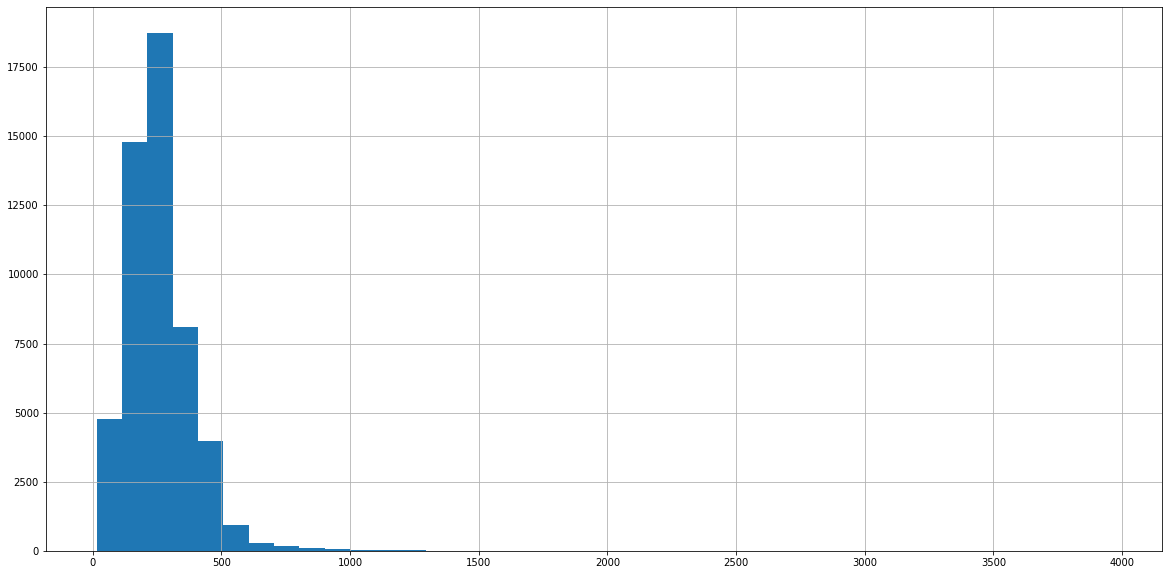

In [ ]:
merged.text.str.split().apply(lambda x: len(x)).hist(bins=40)

In [52]:
tokenizer = AutoTokenizer.from_pretrained(
    'DeepPavlov/rubert-base-cased'
    #do_lower_case=True
)
                                          
encoded_data_train = tokenizer.batch_encode_plus(
    merged.loc[X_train, 'text'].values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    padding='max_length', 
    max_length=300, 
    return_tensors='pt',
    truncation=True
)

encoded_data_val = tokenizer.batch_encode_plus(
    merged.loc[X_val, 'text'].values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    padding='max_length', 
    max_length=300, 
    return_tensors='pt',
    truncation=True
)

In [53]:
with open(
    'drive/MyDrive/data/whole_text/encoded_data_train.pickle', 'wb'
) as f:
  pickle.dump(encoded_data_train, f)

with open(
    'drive/MyDrive/data/whole_text/encoded_data_val.pickle', 'wb'
) as f:
  pickle.dump(encoded_data_val, f)

# Building the model

In [5]:
with open(
    'drive/MyDrive/data/whole_text/encoded_data_train.pickle', 'rb'
) as f:
  encoded_data_train = pickle.load(f)

with open(
    'drive/MyDrive/data/whole_text/encoded_data_val.pickle', 'rb'
) as f:
  encoded_data_val = pickle.load(f)

In [6]:
y_train = np.loadtxt('drive/MyDrive/data/whole_text/y_train.txt')
y_val = np.loadtxt('drive/MyDrive/data/whole_text/y_val.txt')

In [7]:
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(y_train, dtype=torch.long)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(y_val, dtype=torch.long)

In [8]:
dataset_train = TensorDataset(
    input_ids_train, attention_masks_train, labels_train
)
dataset_val = TensorDataset(
    input_ids_val, attention_masks_val, labels_val
)

In [9]:
device = torch.device(
    "cuda" if torch.cuda.is_available() else "cpu"
)
device

device(type='cuda')

In [10]:
#ЗАМЕНИЛ МОДЕЛЬ!

model = BertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-cased",
    num_labels=len(label_dict),
    output_attentions=False,
    output_hidden_states=False
)

model.to(device)

'''model.load_state_dict(
    torch.load('drive/MyDrive/models/finetuned_BERT_epoch_15.model', 
    map_location=torch.device('cpu'))
)'''

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

"model.load_state_dict(\n    torch.load('drive/MyDrive/models/finetuned_BERT_epoch_15.model', \n    map_location=torch.device('cpu'))\n)"

In [11]:
batch_size = 32

dataloader_train = DataLoader(
    dataset_train, 
    sampler=RandomSampler(dataset_train), 
    batch_size=batch_size
)

dataloader_validation = DataLoader(
    dataset_val, 
    sampler=SequentialSampler(dataset_val), 
    batch_size=batch_size
)

In [12]:
optimizer = AdamW(
    model.parameters(),
    lr=1e-5, 
    eps=1e-8
)
                  
epochs = 100

scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=0,
    num_training_steps=len(dataloader_train)*epochs
)

#Training loop


In [ ]:
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(
        dataloader_train, 
        desc='Epoch {:1d}'.format(epoch), 
        leave=False, 
        disable=False
    )
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix(
            {'training_loss': '{:.3f}'.format(loss.item()/len(batch))}
        )
         
        
    torch.save(
        model.state_dict(), 
        f'drive/MyDrive/models/finetuned_BERT_epoch_{epoch}.model'
    )
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')


Epoch 1
Training loss: 1.0984863965400582
Validation loss: 1.0971351481654161
F1 Score (Weighted): 0.18032030483846007



Epoch 2
Training loss: 1.0973372863290087
Validation loss: 1.0969137172757482
F1 Score (Weighted): 0.21025537620324217



Epoch 3
Training loss: 1.0967737340210566
Validation loss: 1.098743642034706
F1 Score (Weighted): 0.26778394613285034



Epoch 4
Training loss: 1.0956633291283593
Validation loss: 1.0957669919253858
F1 Score (Weighted): 0.26191928843493884



Epoch 5
Training loss: 1.092150478822286
Validation loss: 1.0960575802925905
F1 Score (Weighted): 0.29448709887443236



Epoch 6
Training loss: 1.0855411455198063
Validation loss: 1.1062183168036805
F1 Score (Weighted): 0.3300903185293814



Epoch 7
Training loss: 1.0665039488933776
Validation loss: 1.1218278137452764
F1 Score (Weighted): 0.3435083124562591



Epoch 8
Training loss: 1.036795812959228
Validation loss: 1.1844301157933803
F1 Score (Weighted): 0.328999057055561



Epoch 9
Training loss: 1.0013066022936763
Validation loss: 1.2356356393340175
F1 Score (Weighted): 0.32938899375205616



Epoch 10
Training loss: 0.9636673516914492
Validation loss: 1.2231174751293439
F1 Score (Weighted): 0.33391183617298553



Epoch 11
Training loss: 0.9236371238700679
Validation loss: 1.351143401458951
F1 Score (Weighted): 0.3465792820669799



Epoch 12
Training loss: 0.8885683506890073
Validation loss: 1.419351213914485
F1 Score (Weighted): 0.3404057680660324



Epoch 13
Training loss: 0.8433316910405302
Validation loss: 1.4810324848795229
F1 Score (Weighted): 0.3444142285624718



Epoch 14
Training loss: 0.8000462895534077
Validation loss: 1.5886541114994353
F1 Score (Weighted): 0.3322536193548335



Epoch 15
Training loss: 0.7592701432727725
Validation loss: 1.5934879589665887
F1 Score (Weighted): 0.3337316826001395



Epoch 16
Training loss: 0.7218975525125454
Validation loss: 1.7248034535741514
F1 Score (Weighted): 0.34011048258001414



Epoch 17
Training loss: 0.6780791861396995
Validation loss: 1.8592398071581602
F1 Score (Weighted): 0.34328254775133865



Epoch 18
Training loss: 0.633851883485099
Validation loss: 1.8204712531317961
F1 Score (Weighted): 0.34077316276682534
